In [1]:
import ase
import networkx as nx
import os
from monty.serialization import loadfn
from glob import glob
import time
from tqdm import tqdm
import collections
import numpy as np
import matplotlib.pyplot as plt
import ast

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.graphs import MoleculeGraph
from pymatgen.analysis.local_env import OpenBabelNN, CovalentBondNN
from pymatgen.util.graph_hashing import weisfeiler_lehman_graph_hash

from radqm9_pipeline.elements import read_elements
from radqm9_pipeline.modules import merge_data, flatten

# Load data

In [2]:
elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')

In [155]:
base_dir = "/pscratch/sd/m/mavaylon/radqm9pipeline_cut_paste/update_20240123/Trajectories/trajectories"

In [156]:
merged_data=merge_data(base_dir)

100%|██████████| 25/25 [28:01<00:00, 67.25s/it]


# Metadata Analysis

In [5]:
def consolidate_metadata(good_data: list,
                         bad_data: list,
                         export: bool = False):
    """
    
    """
    meta= {}
    total = len(good_data) + len(bad_data)
    
    meta['total'] = total
    meta['removed_total'] = len(bad_data)
    
    bad_meta = {}
    for item in tqdm(bad_data):
        try:
            bad_meta[item['charge_spin']] += 1
        except KeyError:
            bad_meta[item['charge_spin']] = 0
    
    good_meta = {}
    for item in tqdm(good_data):
        try:
            good_meta[item['charge_spin']] += 1
        except KeyError:
            good_meta[item['charge_spin']] = 0
    
    # if sorted(good_meta.keys())!=sorted(bad_meta.keys()):
    #     raise ValueError("keys don't match")
    
    for key in bad_meta:
        meta['removed_'+key] = bad_meta[key]
        meta['total_'+key] = bad_meta[key] + good_meta[key]
        
    return meta
    

# Add charge_spin tag

In [197]:
def charge_spin_tag(data: list):
    """
    
    """
    
    for item in tqdm(data):
        item['charge_spin'] = str(item['charge'])+'_'+str(item['spin'])

In [198]:
charge_spin_tag(merged_data)

100%|██████████| 616729/616729 [00:00<00:00, 1482775.27it/s]


# Bucket 1

In [157]:
len(merged_data)

616729

In [160]:
# merged_data[0]

In [158]:
len(set([x['mol_id'] for x in merged_data]))

133882

### Filter Forces >=10eV

In [219]:
def force_magnitude_filter(cutoff: float,
                           data: list):
    """
    This method returns both data that meets the cuttoff value and data that is equal to or above the cuttoff value.
    If this is run before downsampling, it removes the entire data point trajectory.
    
    Returns: lists
    """
    good = []
    bad = []
    
    for item in tqdm(data):
        forces = item['gradients']
        for path_point in forces:
            next_item = False
            for atom in path_point:
                res = np.sqrt(sum([i**2 for i in atom]))
                if res >= cutoff:
                    bad.append(item)
                    next_item = True
                    break
            if next_item:
                break
        if not next_item:
            good.append(item)
                            
    return good, bad

In [14]:
g_data, b_data = force_magnitude_filter(cutoff=10.0, data=merged_data)

100%|██████████| 616729/616729 [05:12<00:00, 1972.27it/s] 


In [16]:
force_meta = consolidate_metadata(good_data=g_data, bad_data=b_data)

100%|██████████| 616651/616651 [00:00<00:00, 1708634.63it/s]


In [17]:
force_meta
# """
# Remember that these are not data points, but full trajectories that are removed. 
# """

{'total': 616729,
 'removed_total': 78,
 'removed_1_2': 19,
 'total_1_2': 150375,
 'removed_0_1': 0,
 'total_0_1': 141989,
 'removed_0_3': 52,
 'total_0_3': 172845,
 'removed_-1_2': 3,
 'total_-1_2': 151512}

In [29]:
len(merged_data[0]['dipole_moments'])

45

In [49]:
# g_data[0]

# Bucket 2

In [194]:
def flatten_filter(data: dict):
    """
    Flatten bucket to list
    """
    data_to_be_parsed = []
    for mol_id in tqdm(data):
        for pair in data[mol_id]:
            data_to_be_parsed.append(pair)
    return data_to_be_parsed    

In [199]:
def bucket_mol_id(data: list):
    """
    Return: 
    - Good_data--> This means data that either had no duplicates or data that has been able to be mended 
    - bad_ids --> are events that are not able to be mended
    - length is the total number of events both mended and unmended
    
    TODO: fix the merge duplication in geometries, for now this does not matter since we downsample.
  
    """
    bucket = {}
    
    # Step 1    
    """
    Bucket into mol ids
    """
    for event in tqdm(data):
        try:
            bucket[event['mol_id']].append(event) 
        except KeyError:
            bucket[event['mol_id']] = [event]
    
    # Step 2
    """
    Find duplicate pairs in each mol id.
    What are duplicate pairs? These are training sessions that most likely continued as a separate job. 
    They need to be attached if possible. 
    """
    length=0
    bad_ids = []
    for mol_id in tqdm(bucket):
        pairs = [event['charge_spin'] for event in bucket[mol_id]]
        # Get a list of all charge_spins that have duplicates.
        duplicate_pairs = [item for item, count in collections.Counter(pairs).items() if count > 1] 
        if len(duplicate_pairs)!=0:
            """
            Handle the duplicate pairs to see if they can be merged
            """
            len_p = len(bucket[mol_id])
            for dup in duplicate_pairs:
                bad_data = []
                # Order events
                case_events = [event for event in bucket[mol_id] if event['charge_spin']==dup]
                bad_events = []
                bad_events += case_events

                for event in case_events: # remove events to be fixed. If fixable, add back at the end.
                    bucket[mol_id].remove(event) 
        
                ordered = [case_events[0]]
                del case_events[0]
                
                counter = 0
                threshold = 30
                while len(case_events)!=0:
                    if len(bad_data)==0:
                        for event in case_events:
                            beg = event['geometries'][0]
                            end = event['geometries'][len(event['geometries'])-1]

                            ordered_beg = ordered[0]['geometries'][0]
                            ordered_end = ordered[len(ordered)-1]['geometries'][len(ordered[len(ordered)-1]['geometries'])-1]

                            if beg==ordered_end:
                                ordered.append(event)
                                case_events.remove(event)
                            elif end==ordered_beg:
                                ordered.insert(0, event)
                                case_events.remove(event)
                            else:
                                counter+=1
                                if counter>threshold:
                                    bad_data.append(mol_id)
                                else:
                                    continue
                    else:
                        break
                    
                if len(bad_data)==0:                
                    # Merge the ordered events: forces, geometries
                    merged_event = {}
                    merged_event['task_id'] = ordered[0]['task_id']
                    merged_event['mol_id'] = mol_id
                    merged_event['name'] = ordered[0]['name']
                    merged_event['charge'] = ordered[0]['charge']
                    merged_event['spin'] = ordered[0]['spin']
                    merged_event['charge_spin'] = ordered[0]['charge_spin']
                    merged_event['species'] = ordered[0]['species']

                    geometries = []
                    energies = []
                    grads = []
                    mulliken = []
                    resp = []
                    dipole_moments = []
                    dipole_moments_resp = []
                    for event in ordered:
                        geometries += event['geometries']
                        energies += event['energies']
                        grads += event['gradients']
                        mulliken += event['mulliken']
                        resp += event['resp']
                        dipole_moments += event['dipole_moments']
                        dipole_moments_resp += event['dipole_moments_resp']

                    merged_event['geometries'] = geometries
                    merged_event['energies'] = energies
                    merged_event['gradients'] = grads
                    merged_event['mulliken'] = mulliken
                    merged_event['resp'] = resp
                    merged_event['dipole_moments'] = dipole_moments
                    merged_event['dipole_moments_resp'] = dipole_moments_resp

                    bucket[mol_id].append(merged_event)
                else:
                    bad_ids += bad_events
            len_r = len(bucket[mol_id])
            length += len_p-len_r
    good_data = flatten_filter(bucket)
        
    return good_data, bad_ids, length

In [200]:
g_data_bucket, b_data_bucket, length = bucket_mol_id(merged_data)

100%|██████████| 133882/133882 [00:00<00:00, 543766.09it/s]


In [6]:
def add_unique_id(data: list):
    for item in data:
        item['mol_cs'] = str(item['mol_id']) + str(item['charge_spin'])

In [211]:
add_unique_id(g_data_bucket)

In [220]:
g_data, b_data = force_magnitude_filter(cutoff=10.0, data=g_data_bucket)

100%|██████████| 520658/520658 [05:11<00:00, 1670.90it/s]


In [201]:
len(g_data_bucket)

520658

In [23]:
# len(b_data_bucket)
#616729
length+len(g_data_bucket)
# length

616651

In [25]:
len(b_data_bucket)

9131

In [27]:
# g_data_bucket[0]

In [24]:
len(b_data_bucket)+len(g_data_bucket)

529744

In [51]:
616729-616651

78

In [21]:
bucket_meta = consolidate_metadata(good_data=g_data_bucket, bad_data=b_data_bucket)

100%|██████████| 520613/520613 [00:00<00:00, 1381044.30it/s]


In [22]:
bucket_meta

{'total': 529744,
 'removed_total': 9131,
 'removed_0_3': 5328,
 'total_0_3': 136230,
 'removed_1_2': 1598,
 'total_1_2': 133585,
 'removed_0_1': 445,
 'total_0_1': 133809,
 'removed_-1_2': 1756,
 'total_-1_2': 126112}

In [56]:
# def check_duplicate(data: list):
#     bucket = {}
    
#     # Step 1    
#     """
#     Bucket into mol ids
#     """
#     for event in tqdm(data):
#         try:
#             bucket[event['mol_id']].append(event) 
#         except KeyError:
#             bucket[event['mol_id']] = [event]
            
#     duplicate_ids = []
#     for mol_id in tqdm(bucket):
#         pairs = [event['charge_spin'] for event in bucket[mol_id]]
#         # Get a list of all charge_spins that have duplicates.
#         duplicate_pairs = [item for item, count in collections.Counter(pairs).items() if count > 1] 
#         non_dup_pairs = []
#         if len(duplicate_pairs)!=0:
#             non_dup_pairs = list(set(pairs))
#             for i in duplicate_pairs:
#                 non_dup_pairs.remove(i)
        
#         if len(duplicate_pairs)!=0:
#             duplicate_ids.append(mol_id)
#     return duplicate_ids

In [57]:
# check_duplicate(g_data_bucket)

100%|██████████| 133800/133800 [00:00<00:00, 256377.54it/s]


[]

# Downsample and check changes in bonds

In [12]:
def average_force_trajectory(pair):
    """
    This method will take a specfic spin charge pair. At each point in the optimization trajectory, the 
    """
    forces = {}
    for i in range(len(pair['gradients'])):
        temp = []
        for atom in pair['gradients'][i]:
            res = np.sqrt(sum([j**2 for j in atom]))
            temp.append(res)
        forces[i] = np.mean(temp)
    del forces[0]
    return forces

In [18]:
from pymatgen.core.structure import Molecule
from pymatgen.analysis.graphs import MoleculeGraph
from pymatgen.analysis.local_env import OpenBabelNN
from pymatgen.util.graph_hashing import weisfeiler_lehman_graph_hash

# mol1 = Molecule.from_file("test1.xyz")
# mol2 = Molecule.from_file("test2.xyz")

# mg1 = MoleculeGraph.with_local_env_strategy(mol1, OpenBabelNN())
# mg2 = MoleculeGraph.with_local_env_strategy(mol2, OpenBabelNN())

# hash1 = weisfeiler_lehman_graph_hash(mg1.graph.to_undirected(), node_attr="specie")
# hash2 = weisfeiler_lehman_graph_hash(mg2.graph.to_undirected(), node_attr="specie")

# if hash1 == hash2:
#     print("ISOMORPHIC!")
# else:
#     print("DIFFERENT BONDING!")

In [78]:
g_data_bucket[0].keys()

dict_keys(['task_id', 'mol_id', 'name', 'charge', 'spin', 'charge_spin', 'species', 'geometries', 'energies', 'gradients', 'mulliken', 'resp'])

In [106]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/force_filtered_and_merged_bucket.h5', 'w') as file:
    g1 =file.create_group('prior_graph_check')
    raw=[]
    for item in tqdm(g_data_bucket):
        raw.append(str(item))
    g1.create_dataset('somewhat_clean_data',data=raw)

100%|██████████| 520613/520613 [17:22<00:00, 499.29it/s] 


In [107]:
file.close()

In [4]:
import h5py

merged_file = h5py.File('/pscratch/sd/m/mavaylon/new_pipe/force_filtered_and_merged_bucket.h5', 'r')


In [6]:
# merged_data=[]
# for point in tqdm(merged_file['prior_graph_check']['somewhat_clean_data']):
#     point = ast.literal_eval(point.decode('utf-8'))
#     merged_data.append(point)


In [98]:
# atoms = ase.atoms.Atoms(symbols=g_data_bucket[0]['species'],
#                         positions=g_data_bucket[0]['geometries'][0])
# mol = AseAtomsAdaptor.get_molecule(atoms)
# graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())

In [ ]:
def build_graph(species, position):
    atoms = ase.atoms.Atoms(symbols=species,
                            positions=position)
    mol = AseAtomsAdaptor.get_molecule(atoms)
    graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())
    return graph

In [ ]:
def check_bonds(graph1, graph2):
    hash1 = weisfeiler_lehman_graph_hash(graph1.graph.to_undirected(), node_attr="specie")
    hash2 = weisfeiler_lehman_graph_hash(graph2.graph.to_undirected(), node_attr="specie")

    if hash1 == hash2:
        return True
    else:
        return False

In [ ]:
def label_bonds(bucket: list):
    for item in tqdm(bucket):
        g1 = build_graph(item['species'], item['geometries'][0])
        g2 = build_graph(item['species'], item['geometries'][-1])
        change = check_bonds(g1,g2)
        item['bond_change'] = change

In [15]:
def sparse_trajectory(bucket: list):
    """
    This takes the cleaned data and will sparsifiy the optimization trajectories. How this is done will depend on the
    charge_spin pair:
    - Neutral Singlet (0,1): First and Last
    - Other: First, Last, and structure with the highest molecular force other than the First.
    
    Note: Molecular Force is just the average of the force magnitudes of each atom in the molecule:
    """
    
    for pair in tqdm(bucket):
        if pair['charge_spin'] == '0,1':
            geometries = [pair['geometries'][0], pair['geometries'][-1]]
            energies = [pair['energies'][0], pair['energies'][-1]]
            grads = [pair['gradients'][0], pair['gradients'][-1]]
            mulliken = [pair['mulliken'][0], pair['mulliken'][-1]]
            resp = [pair['resp'][0], pair['resp'][-1]]
            dipole_moments = [pair['dipole_moments'][0], pair['dipole_moments'][-1]]
            dipole_moments_resp = [pair['dipole_moments_resp'][0], pair['dipole_moments_resp'][-1]]

            pair['geometries'] = geometries
            pair['energies'] = energies
            pair['gradients'] = grads
            pair['mulliken'] = mulliken
            pair['resp'] = resp
            pair['dipole_moments'] = dipole_moments
            pair['dipole_moments_resp'] = dipole_moments_resp
        else:
            force_dict = average_force_trajectory(pair)
            max_index = max(force_dict, key=force_dict.get)

            geometries = [pair['geometries'][0], pair['geometries'][max_index], pair['geometries'][-1]]
            energies = [pair['energies'][0], pair['energies'][max_index], pair['energies'][-1]]
            grads = [pair['gradients'][0], pair['gradients'][max_index], pair['gradients'][-1]]
            mulliken = [pair['mulliken'][0], pair['mulliken'][max_index], pair['mulliken'][-1]]
            resp = [pair['resp'][0], pair['resp'][max_index], pair['resp'][-1]]
            dipole_moments = [pair['dipole_moments'][0], pair['dipole_moments'][max_index], pair['dipole_moments'][-1]]
            dipole_moments_resp = [pair['dipole_moments_resp'][0], pair['dipole_moments_resp'][max_index], pair['dipole_moments_resp'][-1]]

            pair['geometries'] = geometries
            pair['energies'] = energies
            pair['gradients'] = grads
            pair['mulliken'] = mulliken
            pair['resp'] = resp
            pair['dipole_moments'] = dipole_moments
            pair['dipole_moments_resp'] = dipole_moments_resp

In [16]:
sparse_trajectory(g_data_bucket)

100%|██████████| 520613/520613 [06:13<00:00, 1395.61it/s]


In [17]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/force_filtered_and_merged_bucket.h5', 'w') as file:
    g1 =file.create_group('prior_graph_check')
    raw=[]
    for item in tqdm(g_data_bucket):
        raw.append(str(item))
    g1.create_dataset('somewhat_clean_data',data=raw)

100%|██████████| 520613/520613 [01:44<00:00, 4996.02it/s]


In [6]:
def filter_broken_graphs(data: list):
    broken = []
    good = []
    
    for item in tqdm(data):
        if item['charge_spin'] == '0,1':
            continue
        for traj_point in item['geometries'][1:]: # Ignore the first is in the filter_broken_graphs
                graph = build_graph(item['species'], traj_point)
                connected = nx.is_connected(graph.graph.to_undirected())
                if not connected:
                    broken.append(item)
                else:
                    good.append(item)

    return good, broken

In [16]:
import h5py
merged_file = h5py.File('/pscratch/sd/m/mavaylon/new_pipe/force_filtered_and_merged_bucket.h5', 'r')

In [11]:
# merged_file.close()

In [17]:
merged_data=[]
for point in tqdm(merged_file['prior_graph_check']['somewhat_clean_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_data.append(point)


100%|██████████| 520613/520613 [12:00<00:00, 722.94it/s] 


In [19]:
charge = []
for item in merged_data:
    charge.append(item['charge_spin'])
set(charge)

{'-1,2', '0,1', '0,3', '1,2'}

In [7]:
merged_file.close()

In [3]:
# filtered_good, broken =filter_broken_graphs(merged_data)

In [ ]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/broken.h5', 'w') as file:
    g1 =file.create_group('broken')
    bbd=[]
    for item in broken:
        bbd.append(str(item))
    g1.create_dataset('broken_data',data=bbd)

In [10]:
file.close()

NameError: name 'file' is not defined

In [ ]:
# import h5py
# with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/filtered_out_broken.h5', 'w') as file:
#     g1 =file.create_group('good')
#     bbd=[]
#     for item in filtered_good:
#         bbd.append(str(item))
#     g1.create_dataset('good_data',data=bbd)

In [15]:
import h5py

gg=h5py.File('/pscratch/sd/m/mavaylon/new_pipe/filtered_out_broken.h5', 'r')

In [14]:
gg.close()

In [6]:
# merged_data=[]
# for point in tqdm(merged_file['broken']['broken_data']):
#     point = ast.literal_eval(point.decode('utf-8'))
#     merged_data.append(point)

In [14]:
import h5py

merged_data=[]
for point in tqdm(gg['good']['good_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_data.append(point)

100%|██████████| 747828/747828 [18:27<00:00, 675.14it/s]  


In [15]:
merged_data[0].keys()

dict_keys(['task_id', 'mol_id', 'name', 'charge', 'spin', 'charge_spin', 'species', 'geometries', 'energies', 'gradients', 'mulliken', 'resp', 'dipole_moments', 'dipole_moments_resp'])

In [1]:
label_bonds(merged_data)

In [29]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/labeled_filtered_data.h5', 'w') as file:
    g1 =file.create_group('good')
    bbd=[]
    for item in merged_data:
        bbd.append(str(item))
    g1.create_dataset('good_data',data=bbd)

KeyboardInterrupt: 

In [3]:
# ### read in all clean data
import h5py

gg=h5py.File('/pscratch/sd/m/mavaylon/new_pipe/redone_2024_5_10_full_filtered.h5', 'r')

In [5]:
# import h5py

merged_all_clean_data=[]
for point in tqdm(gg['clean_data']['data']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_all_clean_data.append(point)

100%|██████████| 1014057/1014057 [25:30<00:00, 662.70it/s] 


In [7]:
gg['good']

<HDF5 group "/good" (0 members)>

In [6]:
brok = '/pscratch/sd/m/mavaylon/new_pipe/broken.h5'
brok_file = h5py.File(brok, 'r')

In [7]:
broken_data=[]
for point in tqdm(brok_file['broken']['broken_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    broken_data.append(point)

100%|██████████| 26668/26668 [00:37<00:00, 710.42it/s]


In [8]:
meta = consolidate_metadata(good_data=merged_all_clean_data, bad_data=broken_data)

100%|██████████| 747828/747828 [00:00<00:00, 1624497.09it/s]


In [9]:
meta

{'total': 774496,
 'removed_total': 26668,
 'removed_1,2': 3780,
 'total_1,2': 263974,
 'removed_-1,2': 2220,
 'total_-1,2': 248712,
 'removed_0,3': 20665,
 'total_0,3': 261804}

In [10]:
cs = []
for item in merged_all_clean_data:
    cs.append(item['charge_spin'])

In [11]:
set(cs)

{'-1,2', '0,3', '1,2'}

In [6]:
# merged_all_clean_data[0]

In [312]:
d = []
for item in merged_all_clean_data:
    d.append(item['mol_id'])

In [7]:
add_unique_id(merged_all_clean_data)

In [314]:
len(set(d))

133595

In [8]:
dataset = {}
for item in merged_all_clean_data:
    if item['mol_cs'] in dataset.keys():
        continue
    else:
        dataset[item['mol_cs']] = item

In [9]:
cleaned = [dataset[x] for x in dataset.keys()]

In [10]:
len(cleaned)

511489

In [11]:
cs_pairs = []
for item in cleaned:
    cs_pairs.append(item['charge_spin'])

In [12]:
set(cs_pairs)

{'-1_2', '0_1', '0_3', '1_2'}

In [225]:
weird={}
for item in merged_all_clean_data:
    try:
        weird[item['mol_id']].append(item)
    except KeyError:
        weird[item['mol_id']]=[item]


In [182]:
# weird[3771]

In [191]:
# weird[3771][1]['geometries']

In [226]:
for item in weird[3771]:
    print(item['mol_cs'])

3771-1,2
3771-1,2
37711,2
37711,2
37710,3
37710,3


In [207]:
weird_clean={}
for item in g_data_bucket:
    try:
        weird_clean[item['mol_id']].append(item)
    except KeyError:
        weird_clean[item['mol_id']]=[item]


In [208]:
len(weird_clean[3771])

4

In [209]:
for item in weird_clean[3771]:
    print(item['charge_spin'])

-1_2
0_1
1_2
0_3


In [188]:
weird_clean[3771][0]['geometries'][0]

[[0.0569186954, 1.4096674944, -0.001709418],
 [0.0054170666, -0.0318018292, 0.028159567],
 [-0.1412830738, -0.780151998, -1.0964728289],
 [-0.1538334258, -2.0052618265, -0.7755050913],
 [-0.0135500421, -2.0765450424, 0.5824755282],
 [0.0950753971, -0.8218986107, 1.1630756251],
 [0.23712019, -0.3799626985, 2.3527380281],
 [1.0068618333, 1.7621820669, 0.4098898295],
 [-0.0418037514, 1.7243597933, -1.0403574998],
 [-0.7560860897, 1.8288722166, 0.5977301171],
 [0.0001169509, -2.9735126163, 1.0342690395],
 [0.2803973596, -1.1322914296, 3.0343394934]]

In [187]:
weird_clean[3771][1]['geometries']

[[[0.0569186954, 1.4096674944, -0.001709418],
  [0.0054170666, -0.0318018292, 0.028159567],
  [-0.1412830738, -0.780151998, -1.0964728289],
  [-0.1538334258, -2.0052618265, -0.7755050913],
  [-0.0135500421, -2.0765450424, 0.5824755282],
  [0.0950753971, -0.8218986107, 1.1630756251],
  [0.23712019, -0.3799626985, 2.3527380281],
  [1.0068618333, 1.7621820669, 0.4098898295],
  [-0.0418037514, 1.7243597933, -1.0403574998],
  [-0.7560860897, 1.8288722166, 0.5977301171],
  [0.0001169509, -2.9735126163, 1.0342690395],
  [0.2803973596, -1.1322914296, 3.0343394934]],
 [[0.0867739062, 1.3777589608, 0.0374712789],
  [0.2034619864, -0.0687018174, -0.0668581654],
  [-0.2232239967, -0.8282043134, -1.2684965992],
  [-0.384621745, -2.104711961, -0.7519232929],
  [-0.2359758937, -2.0176412787, 0.7008235787],
  [0.145372515, -0.768062487, 1.1289319685],
  [0.3810238253, -0.3356449745, 2.3155674574],
  [0.9053796924, 1.785948148, 0.6556575597],
  [0.1401768268, 1.8035430311, -0.9704192777],
  [-0.8758794

In [167]:
weird[3771][0]['geometries']

[[[0.0569186954, 1.4096674944, -0.001709418],
  [0.0054170666, -0.0318018292, 0.028159567],
  [-0.1412830738, -0.780151998, -1.0964728289],
  [-0.1538334258, -2.0052618265, -0.7755050913],
  [-0.0135500421, -2.0765450424, 0.5824755282],
  [0.0950753971, -0.8218986107, 1.1630756251],
  [0.23712019, -0.3799626985, 2.3527380281],
  [1.0068618333, 1.7621820669, 0.4098898295],
  [-0.0418037514, 1.7243597933, -1.0403574998],
  [-0.7560860897, 1.8288722166, 0.5977301171],
  [0.0001169509, -2.9735126163, 1.0342690395],
  [0.2803973596, -1.1322914296, 3.0343394934]],
 [[0.0867739062, 1.3777589608, 0.0374712789],
  [0.2034619864, -0.0687018174, -0.0668581654],
  [-0.2232239967, -0.8282043134, -1.2684965992],
  [-0.384621745, -2.104711961, -0.7519232929],
  [-0.2359758937, -2.0176412787, 0.7008235787],
  [0.145372515, -0.768062487, 1.1289319685],
  [0.3810238253, -0.3356449745, 2.3155674574],
  [0.9053796924, 1.785948148, 0.6556575597],
  [0.1401768268, 1.8035430311, -0.9704192777],
  [-0.8758794

## Add partial charge

In [20]:
def transform_partial_spin_charge(data: list):
    for point in tqdm(data):
        pc = []
        ps = []
        for stamp in point['mulliken']:
            substamp_pc = []
            substamp_ps = []
            for atom in stamp:
                substamp_pc.append([atom[0]])
                substamp_ps.append([atom[1]])
            pc.append(substamp_pc)
            ps.append(substamp_ps)
        point['mulliken_partial_spin'] = ps
        point['mulliken_partial_charge'] = pc

In [21]:
transform_partial_spin_charge(merged_all_clean_data)

100%|██████████| 747828/747828 [00:45<00:00, 16431.80it/s]


# Split

In [132]:
# def __mol_id_weight_bins(data: list):
#     """
#     This method takes in the output from removing the broken graphs.
    
#     1. Bin the data by mol_ids in a dict.

#     For each mol_id, calculate the molecule weight based off the atoms. Combine that with that type of atoms used.
#     This weight+type serves as a key for a dict. The values are then the mol_ids that match the key.
    
#     The intent is create a dict such that we can sample from evenly based on weight. We also want to ensure even
#     representation of atom type across train/val/test, hence why we include the atoms used in the key.
#     """
#     bucket={}
#     for item in tqdm(data):
#         try:
#             bucket[item['mol_id']].append(item)
#         except KeyError:
#             bucket[item['mol_id']] = [item]
    
    
#     weight_dist = {}
#     weight_dict = {}
#     f = {}
#     for mol_id in tqdm(bucket):
#         species = bucket[mol_id][0]['species']
#         species_num = []
#         species_sorted = ''.join(sorted(set(species)))
#         for element in species:
#             species_num.append(elements_dict[element])

#         try:
#             weight_dist[str(sum(species_num))]+=1
#         except KeyError:
#             weight_dist[str(sum(species_num))]=1
            
#         try:
#             weight_dict[str(sum(species_num))+'_'+species_sorted].append(mol_id)

#         except KeyError:
#             weight_dict[str(sum(species_num))+'_'+species_sorted] = [mol_id]
    
#     return weight_dict, weight_dist, bucket


In [133]:
# weight_dict, weight_dist, bucket = __mol_id_weight_bins(merged_all_clean_data)

In [134]:
# for key in tqdm(weight_dict):
#     species = []
#     for mol_id in weight_dict[key]:
#         species.append(mol_id['species'])
    
#     if len(list(set(species))) != 1:
#         print(species)
#         print(key)
#         break

In [13]:
def get_molecule_weight(data: list):
    dict_dist = {}
    data_dict = {}
    for item in tqdm(data):
        species_num = []
        species=''.join((sorted(item['species'])))
        
        for element in item['species']:
            species_num.append(elements_dict[element])

        species_sum = sum(species_num)
        try:
            dict_dist[species].append(species_sum)
            # python does a weird thing floats e.g., {126.15499999999993, 126.15499999999994}
            dict_dist[species] = [dict_dist[species][0]]*len(dict_dist[species])
        except KeyError:
            dict_dist[species] = [species_sum]
        
    return dict_dist

In [14]:
def molecule_weight(data: list, weight_dict):
    for item in tqdm(data):
        weight = weight_dict[''.join((sorted(item['species'])))][0]
        item['molecule_mass'] = weight

In [15]:
def weight_to_data(data: list):
    dict_data = {}
    for item in tqdm(data):
        try:
            dict_data[item['molecule_mass']].append(item)
        except KeyError:
            dict_data[item['molecule_mass']] = [item]
    return dict_data

In [16]:
merged_dist = get_molecule_weight(cleaned)
molecule_weight(cleaned, merged_dist)

100%|██████████| 511489/511489 [00:00<00:00, 584664.16it/s]


In [35]:
# merged_dist

In [260]:
d_values = [merged_dist[x] for x in merged_dist.keys()]

In [ ]:
d_values

In [267]:
from itertools import chain

merged_list = list(chain.from_iterable(d_values))


Text(0.5, 0, 'Molecule Mass')

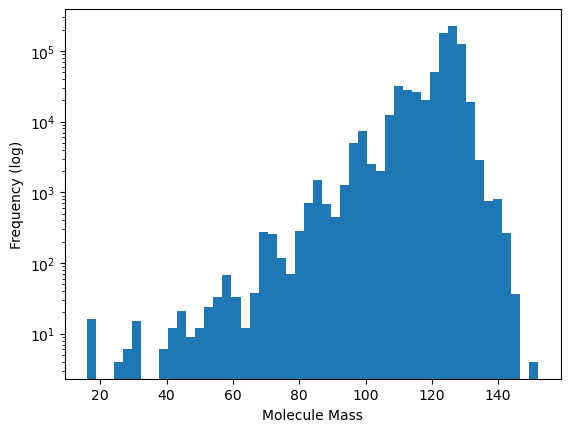

In [321]:
plt.hist(merged_list, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')

In [17]:
#start
wtd = weight_to_data(cleaned)

100%|██████████| 511489/511489 [00:00<00:00, 1281540.83it/s]


In [18]:
length_dict = {key: len(value) for key, value in wtd.items()}
sorted_length_dict = {k: length_dict[k] for k in sorted(length_dict, reverse=True)}


In [20]:
# sorted_length_dict

'\n152.037: 4,\n 144.09200000000007: 29,\n 143.1080000000001: \n '

In [21]:
train_mass = [152.037]
test_mass = [144.09200000000007]
val_mass = [143.1080000000001]

train = sorted_length_dict[152.037] # trackers for dataset sizes
test = sorted_length_dict[144.09200000000007]
val = sorted_length_dict[143.1080000000001]

sorted_length_dict.pop(152.037)
sorted_length_dict.pop(144.09200000000007)
sorted_length_dict.pop(143.1080000000001)


# data is a dict: mass-># of trajs
for mass in sorted_length_dict:
    temp_total = train+val+test
    train_ratio = .65-(train/temp_total)
    test_ratio = .25-(test/temp_total)
    val_ratio = .1-(val/temp_total)
    
    if train_ratio > val_ratio and train_ratio>test_ratio:
        train_mass.append(mass)
        train += sorted_length_dict[mass]
    if val_ratio > train_ratio and val_ratio>test_ratio:
        val_mass.append(mass)
        val += sorted_length_dict[mass]
    if test_ratio > val_ratio and test_ratio>train_ratio:
        test_mass.append(mass)
        test += sorted_length_dict[mass]

In [231]:
sorted_length_dict = {k: length_dict[k] for k in sorted(length_dict, reverse=True)}

In [232]:
# # 30, 40, 50, 60, 70, 90, 105
# switch=[45.04100000000001,
# 54.09200000000001,
# 60.05600000000001,
# 70.05099999999999,
# 72.10699999999997,
# 76.05799999999999,
# 78.06999999999998,
# 84.08199999999998,
# 85.06599999999997,
# 87.08199999999998,
# 88.06199999999998,
# 93.08899999999998,
# 95.10499999999999,
# 97.11699999999996,
# 98.06099999999999,
# 102.09299999999996,
# 102.17699999999992,
# 107.06799999999998]

In [233]:
# for mass in switch:
#     val_mass.append(mass)
#     val += sorted_length_dict[mass]
    
#     test_mass.remove(mass)
#     test -= sorted_length_dict[mass]

ValueError: list.remove(x): x not in list

In [29]:
train/(train+val+test)

0.6499990222726295

In [30]:
val/(train+val+test)

0.100001955454741

In [31]:
test/(train+val+test)

0.2499990222726295

In [22]:
sorted_length_dict = {k: length_dict[k] for k in sorted(length_dict, reverse=True)}

In [23]:
train_subset={key: sorted_length_dict[key] for key in train_mass if key in sorted_length_dict}
test_subset={key: sorted_length_dict[key] for key in test_mass if key in sorted_length_dict}
val_subset={key: sorted_length_dict[key] for key in val_mass if key in sorted_length_dict}

In [24]:
train_foo=[[x]*train_subset[x] for x in train_subset]
test_foo=[[x]*test_subset[x] for x in test_subset]
val_foo=[[x]*val_subset[x] for x in val_subset]


In [25]:
from itertools import chain

train_subset_merged = list(chain.from_iterable(train_foo))
test_subset_merged = list(chain.from_iterable(test_foo))
val_subset_merged = list(chain.from_iterable(val_foo))


Text(0.5, 1.0, 'Train')

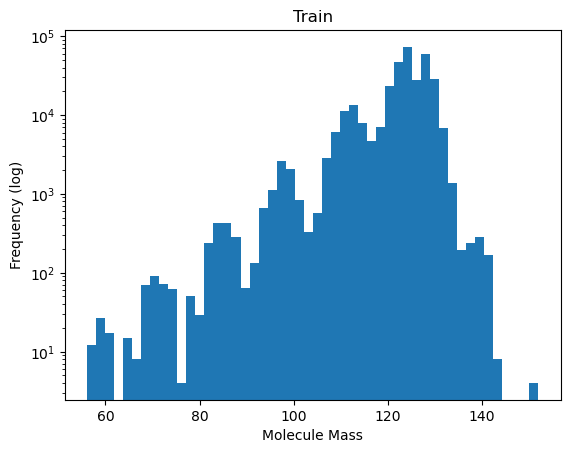

In [26]:
plt.hist(train_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Train')

Text(0.5, 1.0, 'Test')

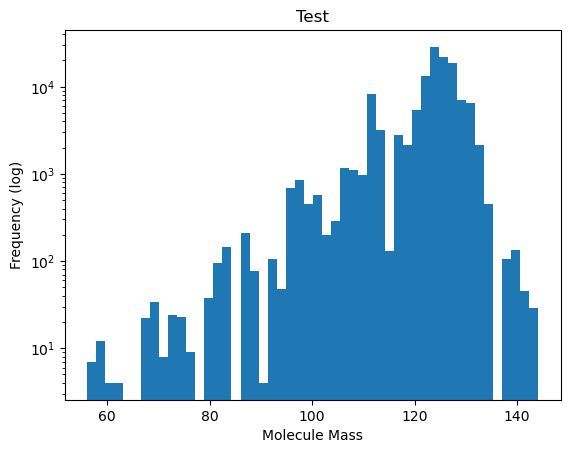

In [33]:
plt.hist(test_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Test')

Text(0.5, 1.0, 'Val')

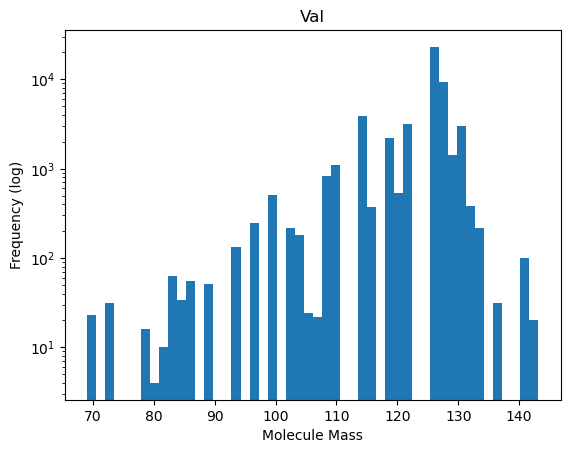

In [34]:
plt.hist(val_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Val')

In [ ]:
30, 40, 50, 60, 70, 90, 105

# Resolve split to trajectories

In [35]:
train_data = [wtd[x] for x in train_mass]
train_data = list(chain.from_iterable(train_data))

val_data = [wtd[x] for x in val_mass]
val_data = list(chain.from_iterable(val_data))

test_data = [wtd[x] for x in test_mass]
test_data = list(chain.from_iterable(test_data))


In [36]:
len(val_data)/(len(train_data)+len(val_data)+len(test_data))

0.100001955454741

In [37]:
len(train_data)/(len(train_data)+len(val_data)+len(test_data))

0.6499990222726295

In [38]:
len(test_data)/(len(train_data)+len(val_data)+len(test_data))

0.2499990222726295

In [39]:
data = {'train':train_data,
        'val': val_data,
        'test': test_data}

In [305]:
def weight_to_species(data: list):
    dict_data = {}
    for item in tqdm(data):
        try:
            dict_data[item['molecule_mass']].append(''.join((sorted(item['species']))))
        except KeyError:
            dict_data[item['molecule_mass']] = [''.join((sorted(item['species'])))]
    return dict_data

In [335]:
wts = weight_to_species(cleaned)

100%|██████████| 133595/133595 [00:00<00:00, 687108.96it/s]


260508

# Charged Data

In [50]:
def charge_filter(charges: list, data):
    """
    Takes both a list of charges to filter by and a dataset that is a list of data points.
    """
    filtered_data = []
    for point in tqdm(data):
        if point['charge'] in charges:
            filtered_data.append(point)
    
    return filtered_data

In [54]:
charge_filtered_training = charge_filter(charges=[-1, 1], data=train_data)

100%|██████████| 332403/332403 [00:00<00:00, 1320735.94it/s]


In [55]:
charge_filtered_val = charge_filter(charges=[-1, 1], data=val_data)

100%|██████████| 51140/51140 [00:00<00:00, 1186296.85it/s]


In [56]:
charge_filtered_test = charge_filter(charges=[-1, 1], data=test_data)

100%|██████████| 127847/127847 [00:00<00:00, 1230902.61it/s]


In [57]:
data_charge = {'train':charge_filtered_training,
        'val': charge_filtered_val,
        'test': charge_filtered_test}

# Ignore

In [25]:
# def train_val_test_split(data: list,
#                          train_size: float,
#                          val_size: float):
#     """
#     This method takes in the output from mol_id_weight_bins.
#     This method will sample from each key-value pair from the input dict based on the train_size, val_size.
#     The method requires a validation set, but the user can combine it with test if they so choose.
#     """
    
#     weight_dict, weight_dist, bucket = __mol_id_weight_bins(data)
    
#     train_marker = train_size
#     val_marker = train_size + val_size
    
#     split={}

#     import random
#     random.seed(10)
#     for strata in tqdm(weight_dict):
#         random.shuffle(weight_dict[strata])
        
#         train_index = round(len(weight_dict[strata])*train_marker)
#         val_index = round(len(weight_dict[strata])*val_marker)

#         try:
#             train_split = (weight_dict[strata][:train_index])
#             val_split = (weight_dict[strata][train_index:val_index+1])
#             test_split = (weight_dict[strata][val_index+1:])
            
#             if len(test_split)> len(val_split):
#                 print('bleh')
#                 return [weight_dict[strata], train_split, val_split, test_split, train_index, val_index+1]
            
#             split['train']+=train_split
#             split['val']+=val_split
#             split['test']+=test_split
            
            
#         except KeyError:
#             split['train'] = weight_dict[strata][:train_index]
#             split['val'] = weight_dict[strata][train_index:val_index+1]
#             split['test'] = weight_dict[strata][val_index+1:]
#     train_data = [bucket[i] for i in split['train']]
#     val_data = [bucket[i] for i in split['val']]
#     test_data = [bucket[i] for i in split['test']]
                 
#     split['train']=train_data
#     split['val']=val_data
#     split['test']=test_data
    
#     return split, weight_dist

In [28]:
# data_dict_spit, weight_dist = train_val_test_split(merged_data, train_size=.65, val_size=.25)

100%|██████████| 1135/1135 [00:00<00:00, 26121.05it/s]


In [31]:
# # training= flatten(data_dict_spit['train'])
# val = flatten(data_dict_spit['val'])
# test = flatten(data_dict_spit['test'])

In [32]:
# data = {'train':training,
#         'val': val,
#         'test': test}

In [35]:
# merged_data[0].keys()

dict_keys(['task_id', 'mol_id', 'name', 'charge', 'spin', 'charge_spin', 'species', 'geometries', 'energies', 'gradients', 'mulliken', 'resp', 'dipole_moments', 'dipole_moments_resp', 'mulliken_partial_spin', 'mulliken_partial_charge'])

# Build Minimal

In [40]:
def build_minimal_atoms(data: dict,
                energy: str = None,
                forces: str = None,
                charge:str = None,
                spin:str = None,
                train = False) -> ase.Atoms:
    """ 
    Populate Atoms class with atoms in molecule.
        atoms.info : global variables
        atoms.array : variables for individual atoms
        
    Both "energy" and "forces" are the dict strings in data.
    """
    atom_list = []
    for i in range(len(data['geometries'])):
        atoms = ase.atoms.Atoms(
            symbols=data['species'],
            positions=data['geometries'][i]
        )
        if energy is not None:
            atoms.info['energy'] = data[energy][i]
        if forces is not None:
            atoms.arrays['forces'] = np.array(data[forces][i])
        if charge is not None:
             atoms.info['charge'] = data[charge]
        if spin is not None:
            atoms.info['spin'] = data[spin]

        if i == 0:
            atoms.info['position_type'] = 'start'
        if i == 1:
            if data['charge_spin'] == '0,1':
                atoms.info['position_type'] = 'end'
            else:
                atoms.info['position_type'] = 'middle'
        if i == 2:
            atoms.info['position_type'] = 'end'
        atom_list.append(atoms)
    return atom_list


In [33]:
def build_full_atoms(data: dict,
                energy: str = None,
                forces: str = None,
                charge:str = None,
                spin:str = None,
                train = False) -> ase.Atoms:
    """ 
    Populate Atoms class with atoms in molecule.
        atoms.info : global variables
        atoms.array : variables for individual atoms
        
    Both "energy" and "forces" are the dict strings in data.
    """
    atom_list = []
    try:
        for i in range(len(data['geometries'])):
            atoms = ase.atoms.Atoms(
                symbols=data['species'],
                positions=data['geometries'][i]
            )
            if energy is not None:
                atoms.info['energy'] = data[energy][i]
            if forces is not None:
                atoms.arrays['forces'] = np.array(data[forces][i])
            if charge is not None:
                 atoms.info['charge'] = data[charge]
            if spin is not None:
                atoms.info['spin'] = data[spin]
            if train:
                atoms.info['chunk'] = data['chunk']
            
            atoms.info['mulliken_partial_charge'] = data['mulliken_partial_charge'][i]
            atoms.info['mulliken_partial_spin'] = data['mulliken_partial_spin'][i]
            atoms.info['mol_id'] = data['mol_id']
            atoms.info['resp'] = data['resp'][i]
            atoms.info['dipole_moments'] = data['dipole_moments'][i]
            atoms.info['dipole_moments_resp'] = data['dipole_moments_resp'][i]
            
            if i == 0:
                atoms.info['position_type'] = 'start'
            if i == 1:
                if data['charge_spin'] == '0,1':
                    atoms.info['position_type'] = 'end'
                else:
                    atoms.info['position_type'] = 'middle'
            if i == 2:
                atoms.info['position_type'] = 'end'
            atom_list.append(atoms)
    except IndexError:
        print(i)
        print(data['mol_id'])
            # print()
            
    return atom_list


In [41]:
def build_minimal_atoms_iterator(data: list,
                         train=False):
    """
    This method assumes the data has been validated. This will create ASE atoms to be written.
    
    The input needs to be a list of lists that contain the event dictionaries. Each inner list needs to represent all the events for a single
    mol_id.
    """
    data_set=[]
    for point in tqdm(data):
        atoms=build_minimal_atoms(point, energy='energies', forces='gradients', charge='charge', spin='spin', train=train)
        data_set+=atoms
    return data_set

In [42]:
build = {}
for split in data:
    if split == 'train':
        build[split] = build_minimal_atoms_iterator(data[split], train=True)
    else:
        build[split] = build_minimal_atoms_iterator(data[split])

100%|██████████| 127847/127847 [00:11<00:00, 10811.91it/s]


In [66]:
build_charge.keys()

dict_keys([])

In [67]:
build_charge = {}
for split in data_charge:
    if split == 'train':
        build_charge[split] = build_minimal_atoms_iterator(data_charge[split], train=True)
    else:
        build_charge[split] = build_minimal_atoms_iterator(data_charge[split])

100%|██████████| 63907/63907 [00:06<00:00, 10459.98it/s]


In [47]:
def create_dataset(data: dict,
                   file_name:str,
                   path:str):
    """
    This method will handle the I/O for writing the data to xyz files to the path provided.
    """
    train_data = data['train']
    val_data = data['val']
    test_data = data['test']
    
    train_file = os.path.join(path,file_name+'_train.xyz')
    ase.io.write(train_file, train_data,format="extxyz")
     
    val_file = os.path.join(path,file_name+'_val.xyz')
    ase.io.write(val_file, val_data,format="extxyz")
    
    test_file = os.path.join(path,file_name+'_test.xyz')
    ase.io.write(test_file, test_data,format="extxyz")

In [48]:
full_data_path ='/pscratch/sd/m/mavaylon/chem_final_data/Traj/Full_data/'

In [60]:
charge_data_path ='/pscratch/sd/m/mavaylon/chem_final_data/Traj/Charge_data/'

In [49]:
#to xyz
create_dataset(build, 'rad_qm9_65_10_25_full_data', full_data_path)

In [73]:
#to xyz
create_dataset(build_charge, 'rad_qm9_65_10_25_charge_data', charge_data_path)

In [68]:
len(build_charge['train'])

495360

In [69]:
len(build_charge['val'])

76230

In [70]:
len(build_charge['test'])

191721

In [71]:
len(build_charge['train'])+len(build_charge['val'])+len(build_charge['test'])

763311

In [40]:
def atom_type_plot(data: list):
    """
    Takes in a list of data points and creates graph to visualize the frequency of each atom type.
    """
    atom_dict={}
    for point in data:
        for atom in point['species']:
            try:
                atom_dict[atom]+=1
            except KeyError:
                atom_dict[atom]=0
    return atom_dict  

In [41]:
d1=atom_type_plot(training)
d3=atom_type_plot(test)
d2=atom_type_plot(val)

{'C': 1199210, 'N': 206532, 'H': 1727014, 'O': 266498, 'F': 5475}

In [42]:
from collections import Counter
z = dict(Counter(d1)+Counter(d2)+Counter(d3))

In [48]:
z

{'N': 796475, 'C': 4716547, 'H': 6798693, 'O': 1046725, 'F': 18755}

In [44]:
{k: float(d1[k])/z[k] for k in d1}


{'N': 0.650206221161995,
 'C': 0.6502000298099436,
 'H': 0.6501545223471629,
 'O': 0.6501105830089088,
 'F': 0.6655825113303119}

In [45]:
{k: float(d2[k])/z[k] for k in d1}


{'N': 0.25930757399792836,
 'C': 0.25425592069791736,
 'H': 0.2540214714798859,
 'O': 0.25460173397979413,
 'F': 0.2919221540922421}

In [46]:
{k: float(d3[k])/z[k] for k in d1}


{'N': 0.09048620484007659,
 'C': 0.09554404949213906,
 'H': 0.09582400617295118,
 'O': 0.09528768301129714,
 'F': 0.04249533457744602}